# What helps projects "kickstart"?
### Purpose of this project is to look at the different live projects in Kickstarter and see how they compare to the most backed projects. We will look into the different factors that may contribute to a project's success.
____

In [222]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go 
import plotly.offline as py
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import string
import country_converter as coco
from scipy.stats import chi2_contingency

In [297]:
livedat = pd.read_csv("live.csv")

In [298]:
## Look into some general details around the dataset
livedat.shape

(4000, 13)

In [299]:
livedat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 13 columns):
Unnamed: 0           4000 non-null int64
amt.pledged          4000 non-null float64
blurb                4000 non-null object
by                   4000 non-null object
country              3999 non-null object
currency             4000 non-null object
end.time             4000 non-null object
location             4000 non-null object
percentage.funded    4000 non-null int64
state                4000 non-null object
title                4000 non-null object
type                 4000 non-null object
url                  4000 non-null object
dtypes: float64(1), int64(2), object(10)
memory usage: 406.4+ KB


In [306]:
livedat["Funded"] = livedat["percentage.funded"] >= 100

In [327]:
livedat.isna().sum()

Unnamed: 0           0
amt.pledged          0
blurb                0
by                   0
country              1
currency             0
end.time             0
location             0
percentage.funded    0
state                0
title                0
type                 0
url                  0
Funded               0
Fundednum            0
dtype: int64

In [308]:
livedat["Fundednum"] = livedat.Funded.astype(int)

### Exploring Logistical Regression with funding amounts

In [333]:
x = livedat['amt.pledged'].astype('int').values.reshape(-1,1)
y = livedat['Askedamt'].astype('int')


In [334]:
model = LogisticRegression(solver='liblinear', random_state=0).fit(x, y)

In [335]:
model.score(x,y)

0.23625

In [ ]:
## It is clear that the amount requested does not support the view strong enough that it is better to request less and secure the funding. 

### Exploring Correlations of funding
____

In [330]:
livedat["Askedamt"] = ((livedat['amt.pledged']*100)/livedat['percentage.funded'])

In [331]:
livedat.loc[livedat['percentage.funded'] < 1, 'Askedamt'] = 0

In [332]:
livedat['amt.pledged'].corr(livedat["percentage.funded"])

0.37204960281344573

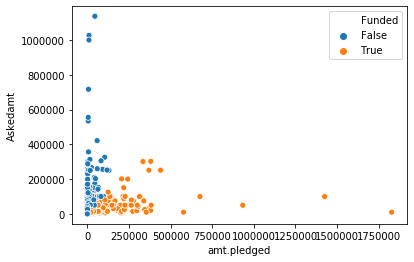

In [289]:
sns.scatterplot(data=livedat, x="amt.pledged", y="Askedamt", hue="Funded")

### Second attempt at looking at text to predict funding.
The focus here will be looking at the blurb attached to each line item and looking to see if there are words that may show indicate success. 

In [264]:
from sklearn.feature_extraction.text import TfidfVectorizer as tfidv

v = tfidv(stop_words='english', max_features=100)
x = v.fit_transform(livedat['blurb'])

In [292]:
livedatwords = pd.DataFrame(x.toarray(), columns=v.get_feature_names())
#print(livedatwords)

In [293]:
livedatres = pd.concat([livedat,livedatwords], axis = 1)
#print(livedatres)

In [294]:
top100 = livedatres.columns

In [269]:
corrls = []
for f in top100[16:]:
    related = livedat['Funded'].corr(livedatres[f])
    corrls.append((f,related))

def Convert(lst):
    res_dct = {lst[i]: lst[i + 1] for i in range(0, len(lst), 2)}
    return res_dct

corrdict = Convert(corrls)

In [270]:
corrdf = pd.DataFrame(corrls, columns=["Word","Correlation"])

In [271]:
corrdf.sort_values("Correlation", ascending=False).head(n=10)

,Word,Correlation
46,inspired,0.068013
16,cards,0.058139
32,featuring,0.056864
10,board,0.052994
25,design,0.042873
19,collection,0.042086
15,card,0.032573
77,set,0.032374
43,high,0.031007
28,easy,0.029772


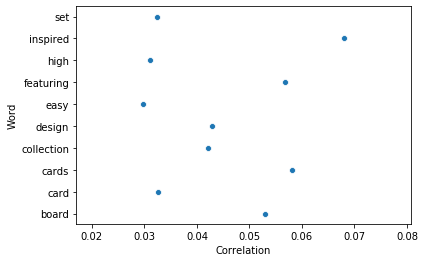

In [286]:
snsout = sns.scatterplot(data=corrdf[corrdf.Correlation>.029],x="Correlation",y="Word")
snsout
#snsfig = snsout.get_figure()
#snsfig.savefig('output.png')

In [273]:
## Find all listings with space, card, city in the title
## [df['A'].str.contains("hello")]
top3reswords = livedatres['blurb'].str.contains('inspired|cards|featuring|board|design|collection|card|set|easy|high')

In [296]:
top3reswordsdf = pd.DataFrame(top3reswords)
#top3reswordsdf

In [276]:
top3reswordsdf = top3reswordsdf.rename(columns={'blurb':'Blurb-TF'})

In [278]:
#top3reswordsdf['Blurb-TF'].value_counts()

False    3292
True      708
Name: Blurb-TF, dtype: int64

In [279]:
#livedatres['Funded'].value_counts()

False    3210
True      790
Name: Funded, dtype: int64

In [280]:
livedatrestop = pd.concat([livedatres,top3reswordsdf], axis = 1)
#sns.scatterplot(data=livedatrestop, x='percentage.funded',hue='title',y='percentage.funded')

In [319]:
barlivedat = livedatrestop.groupby(by=['Blurb-TF'], as_index=False).count()
barlivedat

,Blurb-TF,Unnamed: 0,amt.pledged,blurb,by,country,currency,end.time,location,percentage.funded,...,using,ve,video,want,way,women,work,world,years,young
0,False,3292,3292,3292,3292,3291,3292,3292,3292,3292,...,3292,3292,3292,3292,3292,3292,3292,3292,3292,3292
1,True,708,708,708,708,708,708,708,708,708,...,708,708,708,708,708,708,708,708,708,708


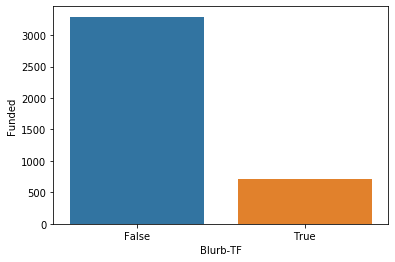

In [321]:
sns.barplot(data=barlivedat,x="Blurb-TF",y="Funded")

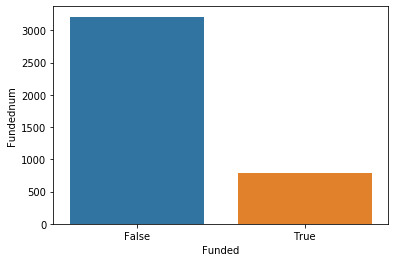

In [324]:
barlivedatoriginal = livedat.groupby(by=['Funded'], as_index=False).count()

sns.barplot(data=barlivedatoriginal,x="Funded",y="Fundednum")

In [323]:
barlivedatoriginal

,Funded,Unnamed: 0,amt.pledged,blurb,by,country,currency,end.time,location,percentage.funded,state,title,type,url,Fundednum
0,False,3210,3210,3210,3210,3209,3210,3210,3210,3210,3210,3210,3210,3210,3210
1,True,790,790,790,790,790,790,790,790,790,790,790,790,790,790


### Exploring Mapping of total projects funded globally
___

In [337]:
livedat_country = livedat.groupby('country', as_index=False).sum()
livedatc_srt = livedat_country.sort_values(by='Funded', ascending=False)

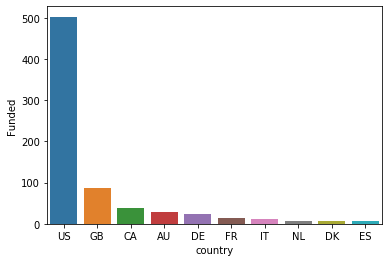

In [338]:
sns.barplot(data=livedatc_srt.head(n=10), x='country',y='Funded')

In [62]:
livedat_country['country'] = coco.convert(names=list(livedat_country.country), to='short_name')

In [63]:
data = dict(type='choropleth',
            locations=livedat_country.country,
            locationmode='country names',
            text=livedat_country.country,
            z=livedat_country.Fundednum,
            ) 

layout = dict(geo = dict(scope='world',
                         showlakes= False),
             title="Number of Projects Funded in Live Data"
             )

choromap = go.Figure(data=[data], layout=layout)
py.iplot(choromap, filename='country map')